<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit spectroscopy
# Step: photom() in Spec2Pipeline

<span style="color:red"> **Instruments Affected**</span>: MIRI 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /Users/kmurray/crds_cache/jwst_ops


<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* os for simple operating system functions
* gwcs.wcstools for bounding box operations
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot shapes
* crds for retrieving a reference file


[Top of Page](#title_ID)

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
import glob
from scipy import interpolate
from IPython.display import Markdown
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, collect_pipeline_cfgs
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from gwcs.wcstools import grid_from_bounding_box
import crds
from jwst import datamodels
from jwst.datamodels import ImageModel
#from ci_watson.artifactory_helpers import get_bigdata

In [4]:
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

<a id="intro_ID"></a>
# Introduction


For this test we are using the **photom** step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/main.html#imaging-and-non-ifu-spectroscopy

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/photom



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

- JWST: James Webb Space Telescope
- MIRI: Mid-Infrared Instrument
- LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

# Run Pipeline steps up to Photom

The simulated data were generated with MIRISim v2.3.0. The observation consists of an observation of a stellar source in the slit, using the ALONG-SLIT-NOD dither pattern. In this scenario, two exposures are executed with the target at 30 and 70% along the length of the slit. These two observations are subtracted from each other for background subtraction, then co-added in the 3rd stage of the pipeline.

In the first steps we run the Detector1 pipeline, and the Spec2 pipeline steps before **photom**.

In [5]:
def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

In [6]:
file_urls = ['https://stsci.box.com/shared/static/4ccmk6jv9lf46jaxklh890d69oywvms7.fits','https://stsci.box.com/shared/static/mj948lyb01ge3aglqxhvy1bwd4bvx1gm.fits']
files = ['jw01536027001_03102_00001_mirimage_uncal.fits','jw01536027001_03102_00002_mirimage_uncal.fits']

In [7]:
box_download_list = [(url,name) for url,name in zip(file_urls,files)]
get_box_files(box_download_list)

print(files)

['jw01536027001_03102_00001_mirimage_uncal.fits', 'jw01536027001_03102_00002_mirimage_uncal.fits']


In [8]:
#Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     #'validation_data',
                                     #'calwebb_spec2',
                                    #'spec2_miri_test',
                                    #'miri_lrs_slit_pt_nod1_v2.3.fits')
 
#Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     #'validation_data',
                                     #'calwebb_spec2',
                                    #'spec2_miri_test',
                                    #'miri_lrs_slit_pt_nod2_v2.3.fits')

#files = [Slitfile1, Slitfile2]

## Detector1 Pipeline

In [9]:
det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, save_results=True)
    det1.append(d1)

print(det1)

2023-03-15 14:25:29,275 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-jumpstep_0001.asdf
2023-03-15 14:25:29,287 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf
2023-03-15 14:25:29,378 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-03-15 14:25:29,379 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-03-15 14:25:29,381 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-03-15 14:25:29,382 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-03-15 14:25:29,384 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2023-03-15 14:25:29,385 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2023-03-15 14:25:29,387 - stpipe.Detector1Pipeline.refpix - 

2023-03-15 14:25:30,839 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0032.fits'.
2023-03-15 14:25:30,839 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0036.fits'.
2023-03-15 14:25:30,840 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2023-03-15 14:25:30,840 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0085.fits'.
2023-03-15 14:25:30,841 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-03-15 14:25:30,841 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_reset_0077.fits'.
2023-03-15 14:25:30,842 - stpipe.Detector1Pipeli

2023-03-15 14:26:13,249 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-03-15 14:26:15,558 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-03-15 14:26:15,909 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).
2023-03-15 14:26:15,910 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2023-03-15 14:26:15,936 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_00

2023-03-15 14:27:26,122 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:27:26,490 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:27:26,530 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:
2023-03-15 14:27:27,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23737 pixels with at least one CR from five or more groups.
2023-03-15 14:27:31,900 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:27:32,258 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:27:32,302 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:
2023-03-15 14:27:32,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23432 pixels with at least one CR from five or more groups

2023-03-15 14:28:58,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:
2023-03-15 14:28:59,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23867 pixels with at least one CR from five or more groups.
2023-03-15 14:29:04,060 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:29:04,408 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:29:04,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:
2023-03-15 14:29:05,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22545 pixels with at least one CR from five or more groups.
2023-03-15 14:29:09,601 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:29:09,944 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000

2023-03-15 14:30:35,100 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:30:35,450 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:30:35,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:
2023-03-15 14:30:36,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23827 pixels with at least one CR from five or more groups.
2023-03-15 14:30:40,794 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:30:41,145 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:30:41,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 42:
2023-03-15 14:30:41,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23404 pixels with at least one CR from five or more grou

2023-03-15 14:31:37,614 - stpipe.Detector1Pipeline.jump - INFO -  In integration 10, number ofshowers in each group = [0, 52, 54, 57, 33, 34, 44, 24, 0, 0, 0, 30, 30, 32, 16, 34, 20, 0, 0, 0, 32, 28, 34, 10, 40, 27, 0, 0, 0, 20, 21, 35, 11, 35, 34, 0, 0, 0, 24, 28, 27, 12, 31, 25, 0, 0, 0, 28, 28, 28, 10, 28, 35, 0, 0, 0, 23, 26, 27, 17, 31, 30, 0, 0, 0, 23, 25, 32, 6, 28, 21, 0, 0, 0, 23, 29, 31, 8, 24, 21, 0, 0, 0, 15, 22, 28, 6, 20, 21, 0, 0, 0, 25, 26, 32, 11, 24, 29, 0]
2023-03-15 14:31:37,980 - stpipe.Detector1Pipeline.jump - INFO -  In integration 11, number ofshowers in each group = [0, 52, 54, 57, 33, 34, 44, 24, 0, 0, 0, 30, 30, 32, 16, 34, 20, 0, 0, 0, 32, 28, 34, 10, 40, 27, 0, 0, 0, 20, 21, 35, 11, 35, 34, 0, 0, 0, 24, 28, 27, 12, 31, 25, 0, 0, 0, 28, 28, 28, 10, 28, 35, 0, 0, 0, 23, 26, 27, 17, 31, 30, 0, 0, 0, 23, 25, 32, 6, 28, 21, 0, 0, 0, 23, 29, 31, 8, 24, 21, 0, 0, 0, 15, 22, 28, 6, 20, 21, 0, 0, 0, 25, 26, 32, 11, 24, 29, 0, 0, 0, 22, 21, 26, 13, 26, 23, 0]
2023-03

2023-03-15 14:31:42,838 - stpipe.Detector1Pipeline.jump - INFO -  In integration 23, number ofshowers in each group = [0, 52, 54, 57, 33, 34, 44, 24, 0, 0, 0, 30, 30, 32, 16, 34, 20, 0, 0, 0, 32, 28, 34, 10, 40, 27, 0, 0, 0, 20, 21, 35, 11, 35, 34, 0, 0, 0, 24, 28, 27, 12, 31, 25, 0, 0, 0, 28, 28, 28, 10, 28, 35, 0, 0, 0, 23, 26, 27, 17, 31, 30, 0, 0, 0, 23, 25, 32, 6, 28, 21, 0, 0, 0, 23, 29, 31, 8, 24, 21, 0, 0, 0, 15, 22, 28, 6, 20, 21, 0, 0, 0, 25, 26, 32, 11, 24, 29, 0, 0, 0, 22, 21, 26, 13, 26, 23, 0, 0, 0, 18, 22, 23, 16, 23, 31, 0, 0, 0, 17, 20, 24, 9, 22, 30, 0, 0, 0, 18, 20, 28, 9, 21, 22, 0, 0, 0, 20, 22, 29, 20, 28, 28, 0, 0, 0, 25, 25, 27, 10, 27, 30, 0, 0, 0, 17, 39, 29, 15, 32, 33, 0, 0, 0, 20, 25, 32, 10, 31, 24, 0, 0, 0, 25, 32, 33, 18, 30, 25, 0, 0, 0, 26, 28, 36, 17, 35, 26, 0, 0, 0, 16, 29, 34, 18, 22, 30, 0, 0, 0, 15, 23, 36, 13, 34, 31, 0, 0, 0, 24, 26, 36, 9, 19, 28, 0]
2023-03-15 14:31:43,182 - stpipe.Detector1Pipeline.jump - INFO -  In integration 24, number of

2023-03-15 14:31:46,209 - stpipe.Detector1Pipeline.jump - INFO -  In integration 32, number ofshowers in each group = [0, 52, 54, 57, 33, 34, 44, 24, 0, 0, 0, 30, 30, 32, 16, 34, 20, 0, 0, 0, 32, 28, 34, 10, 40, 27, 0, 0, 0, 20, 21, 35, 11, 35, 34, 0, 0, 0, 24, 28, 27, 12, 31, 25, 0, 0, 0, 28, 28, 28, 10, 28, 35, 0, 0, 0, 23, 26, 27, 17, 31, 30, 0, 0, 0, 23, 25, 32, 6, 28, 21, 0, 0, 0, 23, 29, 31, 8, 24, 21, 0, 0, 0, 15, 22, 28, 6, 20, 21, 0, 0, 0, 25, 26, 32, 11, 24, 29, 0, 0, 0, 22, 21, 26, 13, 26, 23, 0, 0, 0, 18, 22, 23, 16, 23, 31, 0, 0, 0, 17, 20, 24, 9, 22, 30, 0, 0, 0, 18, 20, 28, 9, 21, 22, 0, 0, 0, 20, 22, 29, 20, 28, 28, 0, 0, 0, 25, 25, 27, 10, 27, 30, 0, 0, 0, 17, 39, 29, 15, 32, 33, 0, 0, 0, 20, 25, 32, 10, 31, 24, 0, 0, 0, 25, 32, 33, 18, 30, 25, 0, 0, 0, 26, 28, 36, 17, 35, 26, 0, 0, 0, 16, 29, 34, 18, 22, 30, 0, 0, 0, 15, 23, 36, 13, 34, 31, 0, 0, 0, 24, 26, 36, 9, 19, 28, 0, 0, 0, 18, 15, 29, 14, 22, 26, 0, 0, 0, 21, 29, 23, 8, 25, 20, 0, 0, 0, 21, 27, 27, 10, 27, 30,

2023-03-15 14:31:48,980 - stpipe.Detector1Pipeline.jump - INFO -  In integration 39, number ofshowers in each group = [0, 52, 54, 57, 33, 34, 44, 24, 0, 0, 0, 30, 30, 32, 16, 34, 20, 0, 0, 0, 32, 28, 34, 10, 40, 27, 0, 0, 0, 20, 21, 35, 11, 35, 34, 0, 0, 0, 24, 28, 27, 12, 31, 25, 0, 0, 0, 28, 28, 28, 10, 28, 35, 0, 0, 0, 23, 26, 27, 17, 31, 30, 0, 0, 0, 23, 25, 32, 6, 28, 21, 0, 0, 0, 23, 29, 31, 8, 24, 21, 0, 0, 0, 15, 22, 28, 6, 20, 21, 0, 0, 0, 25, 26, 32, 11, 24, 29, 0, 0, 0, 22, 21, 26, 13, 26, 23, 0, 0, 0, 18, 22, 23, 16, 23, 31, 0, 0, 0, 17, 20, 24, 9, 22, 30, 0, 0, 0, 18, 20, 28, 9, 21, 22, 0, 0, 0, 20, 22, 29, 20, 28, 28, 0, 0, 0, 25, 25, 27, 10, 27, 30, 0, 0, 0, 17, 39, 29, 15, 32, 33, 0, 0, 0, 20, 25, 32, 10, 31, 24, 0, 0, 0, 25, 32, 33, 18, 30, 25, 0, 0, 0, 26, 28, 36, 17, 35, 26, 0, 0, 0, 16, 29, 34, 18, 22, 30, 0, 0, 0, 15, 23, 36, 13, 34, 31, 0, 0, 0, 24, 26, 36, 9, 19, 28, 0, 0, 0, 18, 15, 29, 14, 22, 26, 0, 0, 0, 21, 29, 23, 8, 25, 20, 0, 0, 0, 21, 27, 27, 10, 27, 30,

2023-03-15 14:31:51,237 - stpipe.Detector1Pipeline.jump - INFO -  In integration 45, number ofshowers in each group = [0, 52, 54, 57, 33, 34, 44, 24, 0, 0, 0, 30, 30, 32, 16, 34, 20, 0, 0, 0, 32, 28, 34, 10, 40, 27, 0, 0, 0, 20, 21, 35, 11, 35, 34, 0, 0, 0, 24, 28, 27, 12, 31, 25, 0, 0, 0, 28, 28, 28, 10, 28, 35, 0, 0, 0, 23, 26, 27, 17, 31, 30, 0, 0, 0, 23, 25, 32, 6, 28, 21, 0, 0, 0, 23, 29, 31, 8, 24, 21, 0, 0, 0, 15, 22, 28, 6, 20, 21, 0, 0, 0, 25, 26, 32, 11, 24, 29, 0, 0, 0, 22, 21, 26, 13, 26, 23, 0, 0, 0, 18, 22, 23, 16, 23, 31, 0, 0, 0, 17, 20, 24, 9, 22, 30, 0, 0, 0, 18, 20, 28, 9, 21, 22, 0, 0, 0, 20, 22, 29, 20, 28, 28, 0, 0, 0, 25, 25, 27, 10, 27, 30, 0, 0, 0, 17, 39, 29, 15, 32, 33, 0, 0, 0, 20, 25, 32, 10, 31, 24, 0, 0, 0, 25, 32, 33, 18, 30, 25, 0, 0, 0, 26, 28, 36, 17, 35, 26, 0, 0, 0, 16, 29, 34, 18, 22, 30, 0, 0, 0, 15, 23, 36, 13, 34, 31, 0, 0, 0, 24, 26, 36, 9, 19, 28, 0, 0, 0, 18, 15, 29, 14, 22, 26, 0, 0, 0, 21, 29, 23, 8, 25, 20, 0, 0, 0, 21, 27, 27, 10, 27, 30,

2023-03-15 14:31:52,780 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 309.845 sec
2023-03-15 14:31:53,233 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 313.261817
2023-03-15 14:31:53,239 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-03-15 14:31:53,605 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00001_mirimage_uncal.fits>,).
2023-03-15 14:31:53,607 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}
2023-03-15 14:31:53,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Usi

2023-03-15 14:41:17,433 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00002_mirimage_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-03-15 14:41:17,436 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0094.fits'.
2023-03-15 14:41:17,437 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0008.fits'.
2023-03-15 14:41:17,438 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0032.fits'.
2023-03-15 14:41:17,439 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kmurray/crds_cache/jwst_ops/references/jwst/

2023-03-15 14:41:56,035 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0032.fits
2023-03-15 14:42:01,840 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-03-15 14:42:02,201 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(50, 10, 1024, 1032) from jw01536027001_03102_00002_mirimage_uncal.fits>,).
2023-03-15 14:42:02,203 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2023-03-15 14:42:02,237 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0017.fits
2023-03-

2023-03-15 14:43:04,212 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:43:04,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:
2023-03-15 14:43:04,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23503 pixels with at least one CR from five or more groups.
2023-03-15 14:43:09,644 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:43:10,017 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:43:10,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:
2023-03-15 14:43:10,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23011 pixels with at least one CR from five or more groups.
2023-03-15 14:43:15,335 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0

2023-03-15 14:44:38,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23125 pixels with at least one CR from five or more groups.
2023-03-15 14:44:42,665 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:44:43,002 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:44:43,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:
2023-03-15 14:44:43,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23678 pixels with at least one CR from five or more groups.
2023-03-15 14:44:48,395 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:44:48,747 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:44:48,789 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 

2023-03-15 14:46:19,626 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:46:19,964 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:46:20,002 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 39:
2023-03-15 14:46:20,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23483 pixels with at least one CR from five or more groups.
2023-03-15 14:46:25,323 - stpipe.Detector1Pipeline.jump - INFO - Flagging 5 groups after detected jumps with e >= 550.0.
2023-03-15 14:46:25,665 - stpipe.Detector1Pipeline.jump - INFO - Flagging 1081 groups after detected jumps with e >= 11000.0.
2023-03-15 14:46:25,701 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:
2023-03-15 14:46:26,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23501 pixels with at least one CR from five or more grou

2023-03-15 14:47:32,364 - stpipe.Detector1Pipeline.jump - INFO -  In integration 8, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0]
2023-03-15 14:47:32,769 - stpipe.Detector1Pipeline.jump - INFO -  In integration 9, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0, 0, 0, 20, 31, 29, 12, 25, 26, 0]
2023-03-15 14:47:33,223 - stpipe.Detector1Pipeline.jump - INFO -  In integration 10, number ofshowers in each group = [0, 27, 33, 38, 25,

2023-03-15 14:47:37,800 - stpipe.Detector1Pipeline.jump - INFO -  In integration 22, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0, 0, 0, 20, 31, 29, 12, 25, 26, 0, 0, 0, 22, 36, 42, 14, 26, 26, 0, 0, 0, 18, 23, 25, 11, 20, 32, 0, 0, 0, 11, 24, 28, 11, 25, 25, 0, 0, 0, 18, 21, 28, 14, 21, 31, 0, 0, 0, 14, 20, 36, 11, 25, 21, 0, 0, 0, 24, 24, 32, 16, 23, 21, 0, 0, 0, 14, 19, 33, 11, 20, 23, 0, 0, 0, 22, 29, 27, 15, 31, 32, 0, 0, 0, 27, 23, 29, 18, 26, 30, 0, 0, 0, 25, 19, 31, 10, 22, 26, 0, 0, 0, 17, 26, 26, 7, 32, 30, 0, 0, 0, 19, 22, 29, 5, 30, 21, 0, 0, 0, 14, 19, 27, 17, 27, 33, 0]
2023-03-15 14:47:38,146 - stpipe.Detector1Pipeline.jump - INFO -  In integration 23, number ofshowers in each group = [0, 27

2023-03-15 14:47:41,338 - stpipe.Detector1Pipeline.jump - INFO -  In integration 31, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0, 0, 0, 20, 31, 29, 12, 25, 26, 0, 0, 0, 22, 36, 42, 14, 26, 26, 0, 0, 0, 18, 23, 25, 11, 20, 32, 0, 0, 0, 11, 24, 28, 11, 25, 25, 0, 0, 0, 18, 21, 28, 14, 21, 31, 0, 0, 0, 14, 20, 36, 11, 25, 21, 0, 0, 0, 24, 24, 32, 16, 23, 21, 0, 0, 0, 14, 19, 33, 11, 20, 23, 0, 0, 0, 22, 29, 27, 15, 31, 32, 0, 0, 0, 27, 23, 29, 18, 26, 30, 0, 0, 0, 25, 19, 31, 10, 22, 26, 0, 0, 0, 17, 26, 26, 7, 32, 30, 0, 0, 0, 19, 22, 29, 5, 30, 21, 0, 0, 0, 14, 19, 27, 17, 27, 33, 0, 0, 0, 15, 19, 22, 10, 26, 30, 0, 0, 0, 18, 26, 29, 18, 28, 26, 0, 0, 0, 25, 27, 25, 12, 25, 22, 0, 0, 0, 23, 26, 29, 12, 33,

2023-03-15 14:47:44,118 - stpipe.Detector1Pipeline.jump - INFO -  In integration 38, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0, 0, 0, 20, 31, 29, 12, 25, 26, 0, 0, 0, 22, 36, 42, 14, 26, 26, 0, 0, 0, 18, 23, 25, 11, 20, 32, 0, 0, 0, 11, 24, 28, 11, 25, 25, 0, 0, 0, 18, 21, 28, 14, 21, 31, 0, 0, 0, 14, 20, 36, 11, 25, 21, 0, 0, 0, 24, 24, 32, 16, 23, 21, 0, 0, 0, 14, 19, 33, 11, 20, 23, 0, 0, 0, 22, 29, 27, 15, 31, 32, 0, 0, 0, 27, 23, 29, 18, 26, 30, 0, 0, 0, 25, 19, 31, 10, 22, 26, 0, 0, 0, 17, 26, 26, 7, 32, 30, 0, 0, 0, 19, 22, 29, 5, 30, 21, 0, 0, 0, 14, 19, 27, 17, 27, 33, 0, 0, 0, 15, 19, 22, 10, 26, 30, 0, 0, 0, 18, 26, 29, 18, 28, 26, 0, 0, 0, 25, 27, 25, 12, 25, 22, 0, 0, 0, 23, 26, 29, 12, 33,

2023-03-15 14:47:46,368 - stpipe.Detector1Pipeline.jump - INFO -  In integration 44, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0, 0, 0, 20, 31, 29, 12, 25, 26, 0, 0, 0, 22, 36, 42, 14, 26, 26, 0, 0, 0, 18, 23, 25, 11, 20, 32, 0, 0, 0, 11, 24, 28, 11, 25, 25, 0, 0, 0, 18, 21, 28, 14, 21, 31, 0, 0, 0, 14, 20, 36, 11, 25, 21, 0, 0, 0, 24, 24, 32, 16, 23, 21, 0, 0, 0, 14, 19, 33, 11, 20, 23, 0, 0, 0, 22, 29, 27, 15, 31, 32, 0, 0, 0, 27, 23, 29, 18, 26, 30, 0, 0, 0, 25, 19, 31, 10, 22, 26, 0, 0, 0, 17, 26, 26, 7, 32, 30, 0, 0, 0, 19, 22, 29, 5, 30, 21, 0, 0, 0, 14, 19, 27, 17, 27, 33, 0, 0, 0, 15, 19, 22, 10, 26, 30, 0, 0, 0, 18, 26, 29, 18, 28, 26, 0, 0, 0, 25, 27, 25, 12, 25, 22, 0, 0, 0, 23, 26, 29, 12, 33,

2023-03-15 14:47:48,361 - stpipe.Detector1Pipeline.jump - INFO -  In integration 49, number ofshowers in each group = [0, 27, 33, 38, 25, 28, 40, 24, 0, 0, 0, 19, 35, 28, 7, 27, 24, 0, 0, 0, 21, 23, 26, 18, 30, 26, 0, 0, 0, 19, 23, 32, 10, 20, 28, 0, 0, 0, 21, 27, 29, 14, 32, 37, 0, 0, 0, 20, 30, 28, 15, 25, 25, 0, 0, 0, 15, 19, 24, 14, 33, 28, 0, 0, 0, 22, 28, 32, 15, 25, 27, 0, 0, 0, 29, 26, 29, 16, 29, 30, 0, 0, 0, 20, 31, 29, 12, 25, 26, 0, 0, 0, 22, 36, 42, 14, 26, 26, 0, 0, 0, 18, 23, 25, 11, 20, 32, 0, 0, 0, 11, 24, 28, 11, 25, 25, 0, 0, 0, 18, 21, 28, 14, 21, 31, 0, 0, 0, 14, 20, 36, 11, 25, 21, 0, 0, 0, 24, 24, 32, 16, 23, 21, 0, 0, 0, 14, 19, 33, 11, 20, 23, 0, 0, 0, 22, 29, 27, 15, 31, 32, 0, 0, 0, 27, 23, 29, 18, 26, 30, 0, 0, 0, 25, 19, 31, 10, 22, 26, 0, 0, 0, 17, 26, 26, 7, 32, 30, 0, 0, 0, 19, 22, 29, 5, 30, 21, 0, 0, 0, 14, 19, 27, 17, 27, 33, 0, 0, 0, 15, 19, 22, 10, 26, 30, 0, 0, 0, 18, 26, 29, 18, 28, 26, 0, 0, 0, 25, 27, 25, 12, 25, 22, 0, 0, 0, 23, 26, 29, 12, 33,

[<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>, <ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>]


## Spec2Pipeline

To run the Spec2Pipeline we first create an association file for the 2 exposures, assigning the nods as each others' backgrounds for background subtraction. We then run the Spec2Pipeline, skipping the final extract1d step.

In [10]:
asn_files = [det1[0].meta.filename, det1[1].meta.filename]
bgr_files = [det1[1].meta.filename, det1[0].meta.filename]

asn = asn_from_list(asn_files, rule=DMSLevel2bBase, meta={'program':'test', 'target':'bd60', 'asn_pool':'test'})

# now add the opposite nod as background exposure:
asn['products'][0]['members'].append({'expname':bgr_files[0], 'exptype':'background'})
asn['products'][1]['members'].append({'expname':bgr_files[1], 'exptype':'background'})

# write this out to a json file
with open('sp2-lrs-slit-test_asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

In [11]:
pipe2 = Spec2Pipeline()
#pipe2.flat_field.save_results = True
pipe2.pathloss.save_results = True
pipe2.extract_1d.skip= True

sp2 = pipe2('sp2-lrs-slit-test_asn.json')
print(sp2)

2023-03-15 14:57:31,898 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-03-15 14:57:31,900 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-03-15 14:57:31,901 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-03-15 14:57:31,902 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-03-15 14:57:31,903 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-03-15 14:57:31,905 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-03-15 14:57:31,908 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-03-15 14:57:31,910 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-03-15 14:57:31,911 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-03-15 14:57:31,913 - stpipe.Spec2Pipeline.

2023-03-15 14:57:32,184 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01536027001_03102_00001_mirimage_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-03-15 14:57:32,191 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-03-15 14:57:32,192 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-03-15 14:57:32,192 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-03-15 14:57:32,192 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-03-15 14:57:32,193 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2

2023-03-15 14:57:33,190 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from jw01536027001_03102_00002_mirimage_rate.fits
2023-03-15 14:57:33,242 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /Users/kmurray/anaconda3/envs/build9.1.1/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:367: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
2023-03-15 14:57:33,243 - stpipe.Spec2Pipeline.bkg_subtract - WARNING -   warnings.warn(
2023-03-15 14:57:33,243 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - 
2023-03-15 14:57:33,450 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-03-15 14:57:33,538 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_rate.fits>,).
2023-03-15 14:57:33,540 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'outp

2023-03-15 14:57:35,368 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_pathloss.fits>,).
2023-03-15 14:57:35,370 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '', 'save_intermediate_results': False, 'ignore_region_min': None, 'ignore_region_max': None}
2023-03-15 14:57:35,370 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.
2023-03-15 14:57:35,374 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe done
2023-03-15 14:57:35,468 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from jw01536027001_03102_0

2023-03-15 14:57:38,998 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-03-15 14:57:38,998 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-03-15 14:57:39,086 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_rate.fits>, ['jw01536027001_03102_00001_mirimage_rate.fits']).
2023-03-15 14:57:39,087 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-03-15 14:57:39,155 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from jw01536027001_03102_00001_mirimage_rate.

2023-03-15 14:57:41,099 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/kmurray/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0085.fits
2023-03-15 14:57:41,100 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-03-15 14:57:41,211 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-03-15 14:57:41,211 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE
2023-03-15 14:57:41,212 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT
2023-03-15 14:57:41,212 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L
2023-03-15 14:57:41,241 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL
2023-03-15 14:57:41,242 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 13.7913
2023-03-15 14:57:41,304 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-03-15 14:57:41,409 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<ImageModel(1024, 1032) from jw015

[<ImageModel(1024, 1032) from jw01536027001_03102_00001_mirimage_cal.fits>, <ImageModel(1024, 1032) from jw01536027001_03102_00002_mirimage_cal.fits>]


In [12]:
for ss in sp2:
    print('Bounding box for {0}: {1}'.format(ss.meta.filename, ss.meta.wcs.bounding_box))
    #bbox_w = photom_nod1.meta.wcs.bounding_box[0][1] - photom_nod1.meta.wcs.bounding_box[0][0]
    #bbox_ht = photom_nod1.meta.wcs.bounding_box[1][1] - photom_nod1.meta.wcs.bounding_box[1][0]

Bounding box for jw01536027001_03102_00001_mirimage_cal.fits: ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=5.5, upper=395.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
)
Bounding box for jw01536027001_03102_00002_mirimage_cal.fits: ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=5.5, upper=395.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
)


(5.5, 395.5)

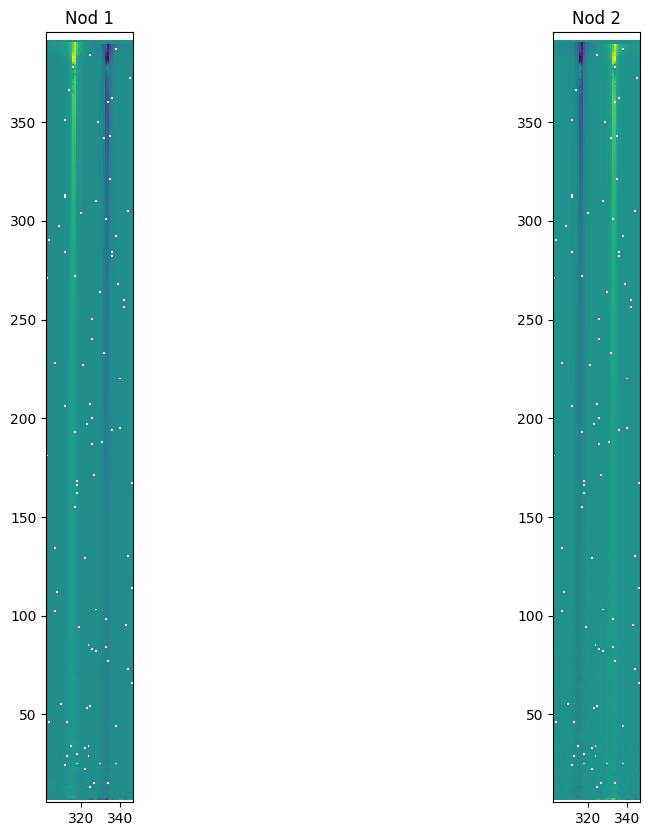

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,10])
ax[0].imshow(sp2[0].data, origin='lower', aspect='equal', interpolation='None')
ax[0].set_title('Nod 1')
ax[0].set_xlim([sp2[0].meta.wcs.bounding_box[0][0], sp2[0].meta.wcs.bounding_box[0][1]])
ax[0].set_ylim([sp2[0].meta.wcs.bounding_box[1][0], sp2[0].meta.wcs.bounding_box[1][1]])

ax[1].imshow(sp2[1].data, origin='lower', aspect='equal', interpolation='None')
ax[1].set_title('Nod 2')
ax[1].set_xlim([sp2[1].meta.wcs.bounding_box[0][0], sp2[1].meta.wcs.bounding_box[0][1]])
ax[1].set_ylim([sp2[1].meta.wcs.bounding_box[1][0], sp2[1].meta.wcs.bounding_box[1][1]])

## Checking the Photom() output

We retrieve the reference file from crds and use that to perform an arithmetic check that the calibration step is correctly implemented at 5 randomly chosen test locations in the bounding box. We also perform a check that the WCS information is consistent between the nods.

2023-03-15 14:57:44,908 - stpipe - WARNING - /var/folders/dz/41vqfd050yq8b664hsvm9hjr0001tk/T/ipykernel_46739/2860770970.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-03-15 14:57:44,908 - stpipe - WARNING -   ffig.show()
2023-03-15 14:57:44,909 - stpipe - WARNING - 
2023-03-15 14:57:44,969 - stpipe - WARNING - /var/folders/dz/41vqfd050yq8b664hsvm9hjr0001tk/T/ipykernel_46739/2860770970.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-03-15 14:57:44,970 - stpipe - WARNING -   ffig.show()
2023-03-15 14:57:44,970 - stpipe - WARNING - 


Point x    Point y   Wavelength
********************************
  317       290   8.635
  317       250   9.689
  310       225   10.269
  334       310    8.031
  340       200   10.798
Point x    Point y   Wavelength
********************************
  317       290   8.635
  317       250   9.689
  310       225   10.269
  334       310    8.031
  340       200   10.798


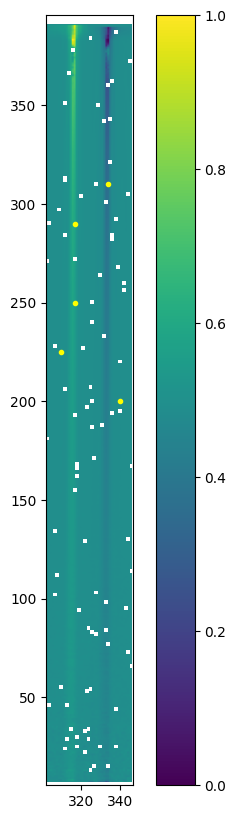

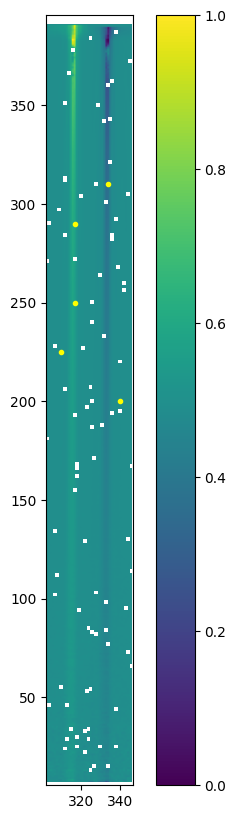

In [14]:
# Make waves
ffig = plt.figure(figsize=[6,10])
print('Point x    Point y   Wavelength')
print('********************************')

point1 = (317,290)
ra1, dec1, wave1 = sp2[0].meta.wcs(point1[0],point1[1])
print('  {0}       {1}   {2:.3f}'.format(point1[0], point1[1], wave1))


point2 = (317,250)
ra2, dec2, wave2 = sp2[0].meta.wcs(point2[0],point2[1])
print('  {0}       {1}   {2:.3f}'.format(point2[0], point2[1], wave2))
point3 = (310,225)
ra3, dec3, wave3 = sp2[0].meta.wcs(point3[0],point3[1])
print('  {0}       {1}   {2:.3f}'.format(point3[0], point3[1], wave3))
point4 = (334,310)
ra4, dec4, wave4 = sp2[0].meta.wcs(point4[0],point4[1])
print('  {0}       {1}    {2:.3f}'.format(point4[0], point4[1], wave4))
point5 = (340,200)
ra5, dec5, wave5 = sp2[0].meta.wcs(point5[0],point5[1])
print('  {0}       {1}   {2:.3f}'.format(point5[0], point5[1], wave5))
plt.imshow(sp2[0].data, origin='lower', aspect='equal')

xpts = [point1[0], point2[0], point3[0], point4[0], point5[0]]
ypts = [point1[1], point2[1], point3[1], point4[1], point5[1]]


plt.xlim([sp2[0].meta.wcs.bounding_box[0][0], sp2[0].meta.wcs.bounding_box[0][1]])
plt.ylim([sp2[0].meta.wcs.bounding_box[1][0], sp2[0].meta.wcs.bounding_box[1][1]])


plt.scatter([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]], color='yellow', marker='.')
plt.colorbar()
ffig.show()

waves = [wave1, wave2, wave3, wave4, wave5]

# Make waves2
ffig = plt.figure(figsize=[6,10])
print('Point x    Point y   Wavelength')
print('********************************')

point1 = (317,290)
ra1, dec1, wave1 = sp2[1].meta.wcs(point1[0],point1[1])
print('  {0}       {1}   {2:.3f}'.format(point1[0], point1[1], wave1))


point2 = (317,250)
ra2, dec2, wave2 = sp2[1].meta.wcs(point2[0],point2[1])
print('  {0}       {1}   {2:.3f}'.format(point2[0], point2[1], wave2))
point3 = (310,225)
ra3, dec3, wave3 = sp2[1].meta.wcs(point3[0],point3[1])
print('  {0}       {1}   {2:.3f}'.format(point3[0], point3[1], wave3))
point4 = (334,310)
ra4, dec4, wave4 = sp2[1].meta.wcs(point4[0],point4[1])
print('  {0}       {1}    {2:.3f}'.format(point4[0], point4[1], wave4))
point5 = (340,200)
ra5, dec5, wave5 = sp2[1].meta.wcs(point5[0],point5[1])
print('  {0}       {1}   {2:.3f}'.format(point5[0], point5[1], wave5))
plt.imshow(sp2[0].data, origin='lower', aspect='equal')

xpts = [point1[0], point2[0], point3[0], point4[0], point5[0]]
ypts = [point1[1], point2[1], point3[1], point4[1], point5[1]]


plt.xlim([sp2[1].meta.wcs.bounding_box[0][0], sp2[1].meta.wcs.bounding_box[0][1]])
plt.ylim([sp2[1].meta.wcs.bounding_box[1][0], sp2[1].meta.wcs.bounding_box[1][1]])


plt.scatter([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]], color='yellow', marker='.')
plt.colorbar()
ffig.show()

waves2 = [wave1, wave2, wave3, wave4, wave5]

Check that the WCS information matches for both nods.

In [15]:
try:
    assert (ww1 == ww2 for ww1, ww2 in zip(waves, waves2))
    print('Wavelengths for points match between nods: Passed')
except:
    print("AssertionError: Wavelengths for points don't match between nods")

#assert(ww1 == ww2 for ww1, ww2 in zip(waves, waves2)), "wavelengths for points points don't match between nods"

Wavelengths for points match between nods: Passed


Now we will check the photometric calibration arithmetic.

**Reminder** : The photom reference file contains a few single values, and then some columns. Amongst the initial single values is 'photmjsr', which is a conversion factor from DN/s to MJy/sr (reffile.phot_table['photmjsr']. Then there are wavelength and relresponse columns, which determine the wavelength-dependent part of the spectral response. At each given pixel, the DN/s slope value in the flat file output file is multiplied by a conversion factor conv_factor, where conv_factor = reffile.phot_table['photmjsr'] * reffile.phot_table['relresponse'] (wave)

In [16]:
reffile = [ss.meta.ref_file.photom.name for ss in sp2]
print(reffile)

try:
    assert reffile[0]==reffile[1]
    print('Nods use the same Photom reference file: Passed')
except:
    print("AssertionError: Nods do not use the same Photom reference file")
#assert reffile[0]==reffile[1], "Nods do not use the same Photom reference file"

# if this test passes and both nods use the same ref file, then just load in once and use for both.
basename = crds.core.config.pop_crds_uri(reffile[0])
filepath = crds.locate_file(basename, "jwst")
ref =  datamodels.open(filepath)

['crds://jwst_miri_photom_0085.fits', 'crds://jwst_miri_photom_0085.fits']
Nods use the same Photom reference file: Passed


[array(1.60016402), array(2.32012667), array(3.23497908), array(1.31306119), array(5.26123054)]


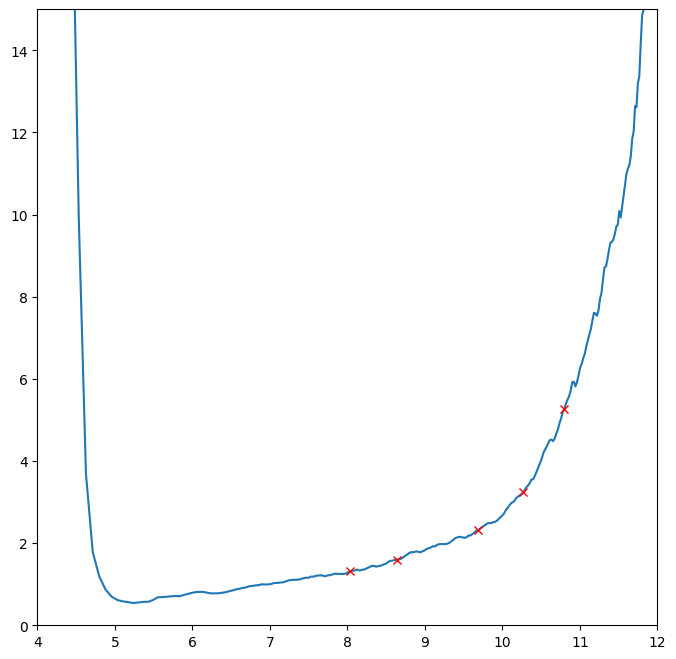

In [17]:
f = interpolate.interp1d(ref.phot_table['wavelength'][0,:], ref.phot_table['relresponse'][0,:])
iresp = [f(ww) for ww in waves]

print(iresp)

# plot for sanity check!
plt.figure(figsize=[8,8])
plt.plot(ref.phot_table['wavelength'][0,:], ref.phot_table['relresponse'][0,:])
plt.plot(waves, iresp, 'rx', label='interpolated points')


plt.xlim([4, 12])
plt.ylim([0,15])

plt.show()

Now create the list of conversion factors for each of these points.

In [18]:
print(ref.phot_table['photmjsr'])

fconv = [ref.phot_table['photmjsr'][0] * ir for ir in iresp]
print(fconv)

[13.791257]
[22.06827314728892, 31.997462931988633, 44.61442763047454, 18.108764170544237, 72.55898205263289]


In the next cell we check that these conversion factors match the ratio of the flat fielded data and the photom-calibrated data at the location of our chosen points.

In [19]:
#ff_files = glob.glob('*flat_field.fits')
ff_files = glob.glob('*pathloss.fits')
print(ff_files)
flat = []

for f in ff_files:
    ffs = datamodels.open(f)
    flat.append(ffs)

print(ff)
    
# make sure we are combining the right nods for both files
if '00001' in sp2[0].meta.filename:
    if '00002' in ff_files[0]:
        flat.reverse()

if '00002' in sp2[0].meta.filename:
    if '00001' in ff_files[0]:
        flat.reverse()

print([ss.meta.filename for ss in sp2])
print([fff.meta.filename for fff in flat])

['jw01536027001_03102_00002_mirimage_pathloss.fits', 'jw01536027001_03102_00001_mirimage_pathloss.fits']
jw01536027001_03102_00002_mirimage_uncal.fits
['jw01536027001_03102_00001_mirimage_cal.fits', 'jw01536027001_03102_00002_mirimage_cal.fits']
['jw01536027001_03102_00001_mirimage_pathloss.fits', 'jw01536027001_03102_00002_mirimage_pathloss.fits']


2023-03-15 14:57:45,939 - stpipe - WARNING - /var/folders/dz/41vqfd050yq8b664hsvm9hjr0001tk/T/ipykernel_46739/1555159195.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-03-15 14:57:45,940 - stpipe - WARNING -   fig.show()
2023-03-15 14:57:45,940 - stpipe - WARNING - 


ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=5.5, upper=395.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
)


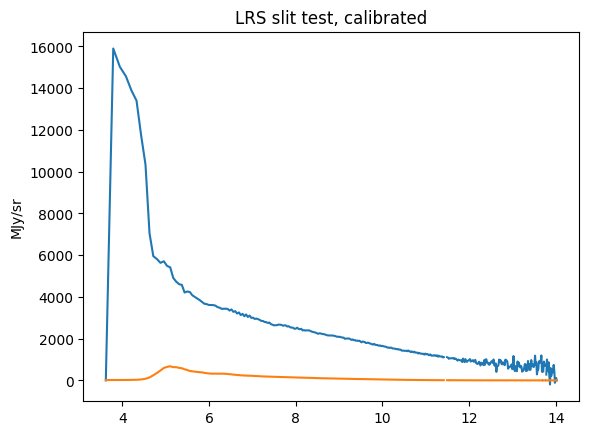

In [20]:
x,y = grid_from_bounding_box(flat[0].meta.wcs.bounding_box)
ra, dec, lam = flat[0].meta.wcs(x, y)

lam_vec = np.mean(lam, axis=1)

print(flat[0].meta.wcs.bounding_box)

flat_test = flat[0].data[6:396, :]
pho_test = sp2[0].data[6:396, :]

fig = plt.figure()
plt.plot(lam_vec, pho_test[:,318])
plt.plot(lam_vec, flat_test[:,318])
plt.title('LRS slit test, calibrated')
plt.ylabel('MJy/sr')
plt.savefig('photom_slit_test_cal.png')
fig.show()

In [21]:
dratio = [sp2[0].data[yy,xx]/flat[0].data[yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, ff in zip(dratio, fconv):
    print('{0:.5f}                {1:.5f}'.format(rr,ff))
    
    try:
        assert np.isclose(rr,ff, rtol=1e-6)
        print('Nods match to within 1e-6: Passed')
    except:
        print("AssertionError: Numbers don't match to within 1e-6")
    #assert np.isclose(rr,ff, rtol=1e-6), "Numbers don't match to within 1e-6"

Ratio of data points     Calculated conversion factor
22.06827                22.06827
Nods match to within 1e-6: Passed
31.99746                31.99746
Nods match to within 1e-6: Passed
44.61441                44.61443
Nods match to within 1e-6: Passed
18.10876                18.10876
Nods match to within 1e-6: Passed
72.55899                72.55898
Nods match to within 1e-6: Passed


Now check the same for Nod 2

In [22]:
dratio2 = [sp2[1].data[yy,xx]/flat[1].data[yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, ff in zip(dratio, fconv):
    print('{0:.5f}                 {1:.5f}'.format(rr,ff))
    try:
        assert np.isclose(rr,ff, rtol=1e-6)
        print('Nods match to within 1e-6: Passed')
    except:
        print("AssertionError: Numbers don't match to within 1e-6")
    #assert np.isclose(rr,ff, rtol=1e-6), "Numbers don't match to within 1e-6"

Ratio of data points     Calculated conversion factor
22.06827                 22.06827
Nods match to within 1e-6: Passed
31.99746                 31.99746
Nods match to within 1e-6: Passed
44.61441                 44.61443
Nods match to within 1e-6: Passed
18.10876                 18.10876
Nods match to within 1e-6: Passed
72.55899                 72.55898
Nods match to within 1e-6: Passed


If these tests return no AssertionErrors, the test has passed.

Authors:
* K. Murray, kmurray@stsci.edu, MIRI Branch
* S. Kendrew, ssarah.kendrew@esa.int, ESA/MIRI Branch

Last updated:
Feb 1st 2021